In [180]:
import csv
import urllib2
import pandas as pd
import numpy as np
import statsmodels as sm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# import data into a pandas dataframe
canc = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", sep=',', 
                  names = ["case", "clump_thick", "uni_cell_size", "uni_cell_shape", "marg_adhesion", "sing_epi_cell_size", "bare_nuclei", "bland_chrom", "norm_nuclei", "mitosis", "status"])
canc.head()

,case,clump_thick,uni_cell_size,uni_cell_shape,marg_adhesion,sing_epi_cell_size,bare_nuclei,bland_chrom,norm_nuclei,mitosis,status
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [169]:
canc.applymap(np.isreal).head()
#something funky is happening with bare_nuclei

,case,clump_thick,uni_cell_size,uni_cell_shape,marg_adhesion,sing_epi_cell_size,bare_nuclei,bland_chrom,norm_nuclei,mitosis,status
0,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True


# Feature engineering

In [221]:
canc = canc[canc.bare_nuclei != '?']
canc.bare_nuclei=canc.bare_nuclei.astype(float)


TypeError: invalid type comparison

# Descriptive Statistics

In [222]:
#checking out new length of dataset after removing ?
len(canc)

683

In [184]:
canc.describe()

,case,clump_thick,uni_cell_size,uni_cell_shape,marg_adhesion,sing_epi_cell_size,bare_nuclei,bland_chrom,norm_nuclei,mitosis,status
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [187]:
#we can see that malignant cells have generally larger values across the board compared to benign tumors, with clump thickness being especially large
canc.groupby('status').mean()

,case,clump_thick,uni_cell_size,uni_cell_shape,marg_adhesion,sing_epi_cell_size,bare_nuclei,bland_chrom,norm_nuclei,mitosis
status,,,,,,,,,,
2,1.115261e+06,2.963964,1.306306,1.414414,1.346847,2.108108,1.346847,2.083333,1.261261,1.065315
4,1.005121e+06,7.188285,6.577406,6.560669,5.585774,5.326360,7.627615,5.974895,5.857741,2.602510


In [82]:
#we can see that larger clumps (9-10) are strongly related to malignant tumors
canc.groupby('clump_thick').mean()

,case,uni_cell_size,uni_cell_shape,marg_adhesion,sing_epi_cell_size,bland_chrom,norm_nuclei,mitosis,class
clump_thick,,,,,,,,,
1,1.088915e+06,1.179310,1.351724,1.296552,2.020690,2.048276,1.213793,1.103448,2.041379
2,1.099968e+06,1.500000,1.500000,1.500000,2.280000,2.300000,1.440000,1.140000,2.160000
3,1.070008e+06,1.759259,1.777778,1.842593,2.453704,2.518519,1.629630,1.194444,2.222222
4,1.179235e+06,2.150000,2.075000,2.000000,2.400000,2.987500,1.887500,1.125000,2.300000
5,1.072220e+06,3.207692,3.461538,3.223077,3.492308,3.315385,3.007692,1.423077,2.692308
6,1.075532e+06,5.205882,4.794118,4.294118,4.235294,4.970588,5.117647,2.235294,3.058824
7,9.347940e+05,5.086957,5.260870,5.652174,4.565217,5.652174,5.217391,2.652174,3.913043
8,9.748091e+05,6.739130,6.695652,4.782609,5.108696,5.586957,6.282609,2.413043,3.826087
9,1.106483e+06,7.000000,7.642857,4.928571,6.500000,5.142857,6.000000,3.500000,4.000000


# Plotting data distribution

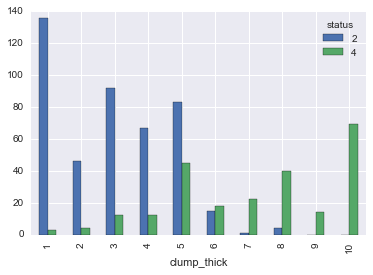

In [192]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plot correlation of variables
corr = canc.corr()
#viewing distributions
#plt.hist(canc.clump_thick)
# plt.hist(canc.uni_cell_size)

#grouping clump thickness by class
# canc['clump_thick'].hist(by=canc['class'])
# plt.xlabel('clump thickness')
# plt.ylabel('Frequency')

pd.crosstab(canc.clump_thick, canc['status']).plot(kind='bar')
#we can see that there's a strong distinction of clump_thickness in determining class

# Analyzing data using Logistic Regression (Sklearn)

In [197]:
X = canc[["clump_thick", "uni_cell_size", "uni_cell_shape", "marg_adhesion", "sing_epi_cell_size", "bare_nuclei", "bland_chrom", "norm_nuclei", "mitosis"]]
y = canc.status
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.96925329428989748

In [155]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,clump_thick,[0.245155155304]
1,uni_cell_size,[0.161425713422]
2,uni_cell_shape,[0.271616385637]
3,marg_adhesion,[0.179466749001]
4,sing_epi_cell_size,[-0.0415878421435]
5,bare_nuclei,[0.346989536605]
6,bland_chrom,[0.181592803655]
7,norm_nuclei,[0.191305984559]
8,mitosis,[0.206342363555]


In [194]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [164]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[  9.09726028e-01   9.02739720e-02]
 [  9.76978089e-01   2.30219110e-02]
 [  4.64410643e-02   9.53558936e-01]
 [  1.90154530e-02   9.80984547e-01]
 [  9.82769244e-01   1.72307563e-02]
 [  9.57892643e-01   4.21073568e-02]
 [  9.38825728e-01   6.11742720e-02]
 [  2.69830925e-03   9.97301691e-01]
 [  9.51853815e-01   4.81461848e-02]
 [  9.81713646e-01   1.82863544e-02]
 [  6.02971769e-03   9.93970282e-01]
 [  9.65616434e-01   3.43835656e-02]
 [  2.15279014e-03   9.97847210e-01]
 [  9.76978089e-01   2.30219110e-02]
 [  9.56085186e-01   4.39148140e-02]
 [  8.46693023e-01   1.53306977e-01]
 [  2.71670328e-02   9.72832967e-01]
 [  2.84788880e-03   9.97152111e-01]
 [  7.11278054e-03   9.92887219e-01]
 [  9.61889032e-01   3.81109677e-02]
 [  9.76978089e-01   2.30219110e-02]
 [  9.71598618e-01   2.84013823e-02]
 [  2.47536182e-01   7.52463818e-01]
 [  9.78301010e-01   2.16989904e-02]
 [  3.49555412e-02   9.65044459e-01]
 [  7.73914249e-03   9.92260858e-01]
 [  9.47319273e-01   5.26807268e-02]
 

In [213]:
predicted = model2.predict(X_test)
print predicted

[2 2 4 4 2 2 2 4 2 2 4 2 4 2 2 2 4 4 4 2 2 2 4 2 4 4 2 2 2 4 2 4 4 2 2 2 4
 4 2 4 2 2 2 2 2 2 2 4 2 2 4 2 4 2 2 2 4 4 2 4 2 2 2 2 2 2 2 2 4 4 2 2 2 2
 2 2 4 2 2 2 4 2 4 2 2 4 2 4 4 2 4 2 4 2 2 4 4 4 2 2 2 2 4 4 2 2 4 2 2 2 4
 2 2 4 2 2 2 2 2 2 2 4 2 2 4 4 2 4 2 4 2 2 4 2 2 4 2 4 2 2 2 2 2 2 2 4 4 2
 4 2 4 2 2 2 2 2 4 4 2 4 4 4 4 2 4 2 2 2 2 2 2 4 4 4 2 2 2 4 2 2 4 2 2 4 2
 2 4 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4]


In [214]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)


0.936585365854


In [167]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[126   4]
 [  9  66]]
             precision    recall  f1-score   support

          2       0.93      0.97      0.95       130
          4       0.94      0.88      0.91        75

avg / total       0.94      0.94      0.94       205



# Cross-validate model using 10-fold cross-validation

In [168]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.91304348  0.91304348  0.94202899  0.94202899  0.98529412  0.97058824
  0.97058824  0.98529412  0.98529412  1.        ]
0.960720375107


# Cross-validating using SVM

In [220]:
from sklearn import svm
B = canc[["clump_thick", "uni_cell_size", "uni_cell_shape", "marg_adhesion", "sing_epi_cell_size", "bare_nuclei", "bland_chrom", "norm_nuclei", "mitosis"]]
a = canc.status
B_train, B_test, a_train, a_test = train_test_split(B, a, test_size=0.3, random_state=0)


clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, B, a, cv=5)
scores    


array([ 0.94890511,  0.94890511,  0.97810219,  0.97080292,  0.98518519])

In [203]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.03)


# Attempting to Plot...but failing

In [218]:
C=1.0
classifiers = {'L1 logistic': LogisticRegression(C=C, penalty='l1'),
               'Linear SVC': svm(kernel='linear', C=C, probability=True,
                                 random_state=0)
               }

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    classif_rate = np.mean(y_pred.ravel() == y.ravel()) * 100
    print("classif_rate for %s : %f " % (name, classif_rate))

    # View probabilities=
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(3, 9, 1, 5), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

TypeError: 'module' object is not callable